## POS tagging using modified Viterbi Algorithm

### Problem Statement:
The Vanilla Viterbi Algorithm initially developed had tagged the first tag by default for the words that are not present in the corpus that is used for training. This led to a drop in the accuracy by approximately 13%.
### Objective: 
To modify the Vanilla Viterbi Algorithm using any two approaches to assign tags correctly for the unknown words.
### Two approaches implemented in this assignment:
1. Modified the Viterbi Algorithm to tag the unknown words using only the maximum likelihood of transition probabilities of the Tags for unknown words.
2. Modified the Viterbi Algorithm to tag unknown words using Rules based POS Tagging.

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences using UNIVERSAL Tags
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

####                                                     UNIVERSAL TAGS

| Tag | Meaning | English Examples |
| --- | --- | --- |
| ADJ | adjective  | new, good, high, special, big, local |
| ADP | adposition |	on, of, at, with, by, into, under |
| ADV | adverb	   | really, already, still, early, now   |
| CONJ|	conjunction| and, or, but, if, while, although    |
|DET  | determiner, article	| the, a, some, most, every, no, which |
|NOUN | noun	   | year, home, costs, time, Africa      |
|NUM  |	numeral    |	twenty-four, fourth, 1991, 14:24  |
|PRT  |	particle   |	at, on, out, over per, that, up, with |
|PRON |pronoun	   |he, their, her, its, my, I, us        |
|VERB |	verb	   |is, say, told, given, playing, would  |
|.	  |punctuation marks|	. , ; !                       |
|X	  |other       |	ersatz, esprit, dunno, gr8, univeristy|

In [3]:
# First three sentences of the corpus
nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [4]:
# converting the list of sents to a list of (word, POS tag) tuples
tagged_words = [tup for sent in nltk_data for tup in sent]
print("Total number of words tagged in Treebank Corpus using Universal Tags: ", len(tagged_words))
tagged_words[:10]


Total number of words tagged in Treebank Corpus using Universal Tags:  100676


[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET')]

### Exploratory Data Analysis

In [5]:
# Unique tags in the corpus
tags = [pair[1] for pair in tagged_words]
unique_tags = set(tags)
print("Number of unique Tags: ",len(unique_tags))


Number of unique Tags:  12


In [6]:
from collections import Counter
tag_counts = Counter(tags)
print("Tags and Counts: ",tag_counts)


Tags and Counts:  Counter({'NOUN': 28867, 'VERB': 13564, '.': 11715, 'ADP': 9857, 'DET': 8725, 'X': 6613, 'ADJ': 6397, 'NUM': 3546, 'PRT': 3219, 'ADV': 3171, 'PRON': 2737, 'CONJ': 2265})


In [7]:
print ("Top 5 most common tags:")
tag_counts.most_common(5)


Top 5 most common tags:


[('NOUN', 28867), ('VERB', 13564), ('.', 11715), ('ADP', 9857), ('DET', 8725)]

### Creating Train Set and Validation Set in the ratio of 95:5

In [8]:
# Splitting into train and test
# random.seed(1234)
train_set, valdn_set = train_test_split(nltk_data,test_size=0.05, random_state=100)
print("Number of sentences in Train Set: ",len(train_set))
print("Number of sentences in Validation Set: ",len(valdn_set))
print("First 10 sentences of Train Data:")
print(train_set[:10])


Number of sentences in Train Set:  3718
Number of sentences in Validation Set:  196
First 10 sentences of Train Data:
[[('One', 'NUM'), ('bright', 'ADJ'), ('sign', 'NOUN'), ('is', 'VERB'), ('that', 'ADP'), ('a', 'DET'), ('growing', 'VERB'), ('number', 'NOUN'), ('of', 'ADP'), ('women', 'NOUN'), ('have', 'VERB'), ('entered', 'VERB'), ('the', 'DET'), ('once', 'ADV'), ('male-dominated', 'ADJ'), ('field', 'NOUN'), (';', '.'), ('more', 'ADJ'), ('than', 'ADP'), ('a', 'DET'), ('third', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('ringers', 'NOUN'), ('today', 'NOUN'), ('are', 'VERB'), ('women', 'NOUN'), ('.', '.')], [('``', '.'), ('These', 'DET'), ('days', 'NOUN'), (',', '.'), ('banking', 'NOUN'), ('customers', 'NOUN'), ('walk', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('door', 'NOUN'), ('*-1', 'X'), ('expecting', 'VERB'), ('you', 'PRON'), ('to', 'PRT'), ('have', 'VERB'), ('a', 'DET'), ('package', 'NOUN'), ('especially', 'ADV'), ('for', 'ADP'), ('them', 'PRON'), (',', '.'), ("''", '.'), ('Ms.', 'NOU

In [9]:
print("First 10 sentences of Validation Data:")
valdn_set[:10]


First 10 sentences of Validation Data:


[[('Investors', 'NOUN'),
  ('took', 'VERB'),
  ('advantage', 'NOUN'),
  ('of', 'ADP'),
  ('Tuesday', 'NOUN'),
  ("'s", 'PRT'),
  ('stock', 'NOUN'),
  ('rally', 'NOUN'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('book', 'VERB'),
  ('some', 'DET'),
  ('profits', 'NOUN'),
  ('yesterday', 'NOUN'),
  (',', '.'),
  ('*-1', 'X'),
  ('leaving', 'VERB'),
  ('stocks', 'ADV'),
  ('up', 'ADP'),
  ('fractionally', 'ADV'),
  ('.', '.')],
 [('Buying', 'VERB'),
  ('for', 'ADP'),
  ('the', 'DET'),
  ('most', 'ADJ'),
  ('part', 'NOUN'),
  ('carried', 'VERB'),
  ('over', 'PRT'),
  ('from', 'ADP'),
  ('the', 'DET'),
  ('previous', 'ADJ'),
  ('session', 'NOUN'),
  (',', '.'),
  ('and', 'CONJ'),
  ('traders', 'NOUN'),
  ('apparently', 'ADV'),
  ('ignored', 'VERB'),
  ('reports', 'NOUN'),
  ('that', 'ADP'),
  ('a', 'DET'),
  ('Chilean', 'ADJ'),
  ('mine', 'ADJ'),
  ('strike', 'NOUN'),
  ('may', 'VERB'),
  ('have', 'VERB'),
  ('ended', 'VERB'),
  ('almost', 'ADV'),
  ('before', 'ADP'),
  ('it', 'PRON'),
  ('began',

In [10]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Number of tagged words in Train Data: ",len(train_tagged_words))


Number of tagged words in Train Data:  95949


In [11]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
print("Initial 10 tagged words in train data")
tokens[:10]


Initial 10 tagged words in train data


['One',
 'bright',
 'sign',
 'is',
 'that',
 'a',
 'growing',
 'number',
 'of',
 'women']

In [12]:
# vocabulary
V = set(tokens)
print("Size of Vocabulary: ",len(V))


Size of Vocabulary:  12106


In [13]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print("Number of Tags: ",len(T))


Number of Tags:  12


In [14]:
print("Set of unique Tags: ",T)

Set of unique Tags:  {'NUM', '.', 'ADJ', 'NOUN', 'ADP', 'PRON', 'VERB', 'ADV', 'CONJ', 'PRT', 'DET', 'X'}


## Hidden Markov Model

- Markov processes are commonly used to model sequential data, such as text and speech.
- The Hidden Markov Model (HMM) is an extension to the Markov process which is used to model phenomena where the states are hidden (or latent) and they emit observations.
- In POS tagging, we can only observe words in a sentence, while the POS tags themselves are hidden.
- The hidden states emit observations with a certain probability.
- Hidden Markov Models also have emission probabilities which represent the probability that an observation is emitted by a particular state.


### Calculations of Emission and Transition Probabilities

### Emission Probabilities

Emission Probability of a word 'w' for tag 't':

P(w|t) = Number of times w has been tagged t / Number of times t appears

In [15]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [16]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [17]:
# examples

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'X'))
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))



 large
(28, 6105)
(0, 12919)
(0, 27539) 


 will
(0, 6301)
(1, 27539)
(262, 12919)

 book
(7, 27539)
(0, 12919)


From the emission probabilities we observe that
- The probability of the word 'large' being a an ADJ (Adjective) is higher than all other possibilities
- The probability of word 'will' being a VERB (verb) is higher than all other possibilities
- The probability of word 'book' being a NOUN (Noun) is higher than all other possibilities


### Transition Probabilities

Transition Probability of tag t1 followed by tag t2:

P(t2|t1) = Number of times t1 is followed by tag t2/ Number of times t1 appears

In [18]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [19]:
# Example
print(t2_given_t1(t2='VERB', t1='NOUN')[0]/t2_given_t1(t2='VERB', t1='NOUN')[1])


0.14695522713243037


The transition probability of Verb given Noun is 14.69%

In [20]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [21]:
tags_matrix

array([[1.84194893e-01, 1.18835412e-01, 3.35710049e-02, 3.52346987e-01,
        3.50564457e-02, 1.48544263e-03, 1.69340465e-02, 2.67379684e-03,
        1.30718956e-02, 2.61437912e-02, 3.86215094e-03, 2.11824119e-01],
       [8.13525841e-02, 9.29231346e-02, 4.36810479e-02, 2.22531170e-01,
        9.22055766e-02, 6.52076453e-02, 8.87075067e-02, 5.22916839e-02,
        5.80321103e-02, 2.51143589e-03, 1.73558161e-01, 2.69082431e-02],
       [2.08026208e-02, 6.38820603e-02, 6.71580657e-02, 7.00900912e-01,
        7.86240771e-02, 4.91400482e-04, 1.17936116e-02, 4.91400482e-03,
        1.60524156e-02, 1.01556098e-02, 4.91400482e-03, 2.03112196e-02],
       [9.55009274e-03, 2.39950612e-01, 1.21645667e-02, 2.64279753e-01,
        1.77057996e-01, 4.72057797e-03, 1.46955222e-01, 1.68125201e-02,
        4.29209471e-02, 4.33566943e-02, 1.33628668e-02, 2.88681500e-02],
       [6.19103163e-02, 3.97540554e-02, 1.07388951e-01, 3.21212769e-01,
        1.74917839e-02, 6.91190511e-02, 8.48086551e-03, 1.33

In [22]:
# convert the matrix to a df for better readability
import pandas as pd
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [23]:
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_df

,NUM,.,ADJ,NOUN,ADP,PRON,VERB,ADV,CONJ,PRT,DET,X
NUM,0.184195,0.118835,0.033571,0.352347,0.035056,0.001485,0.016934,0.002674,0.013072,0.026144,0.003862,0.211824
.,0.081353,0.092923,0.043681,0.222531,0.092206,0.065208,0.088708,0.052292,0.058032,0.002511,0.173558,0.026908
ADJ,0.020803,0.063882,0.067158,0.700901,0.078624,0.000491,0.011794,0.004914,0.016052,0.010156,0.004914,0.020311
NOUN,0.009550,0.239951,0.012165,0.264280,0.177058,0.004721,0.146955,0.016813,0.042921,0.043357,0.013363,0.028868
ADP,0.061910,0.039754,0.107389,0.321213,0.017492,0.069119,0.008481,0.013357,0.000848,0.001484,0.323969,0.034984
PRON,0.007280,0.040613,0.072031,0.211494,0.023372,0.007663,0.484291,0.034100,0.004981,0.012261,0.009195,0.092720
VERB,0.022448,0.034291,0.065640,0.111386,0.091184,0.035916,0.168744,0.082050,0.005186,0.031427,0.133292,0.218438
ADV,0.031624,0.135153,0.130160,0.031624,0.119507,0.015646,0.344541,0.077230,0.006991,0.014314,0.069907,0.023302
CONJ,0.042188,0.035698,0.118683,0.350487,0.053778,0.058414,0.155308,0.053778,0.000464,0.003709,0.118683,0.008809
PRT,0.056102,0.043635,0.083661,0.245735,0.019357,0.017717,0.405184,0.010171,0.002297,0.001969,0.101050,0.013123


In [24]:
tags_df.loc['.', :]

NUM     0.081353
.       0.092923
ADJ     0.043681
NOUN    0.222531
ADP     0.092206
PRON    0.065208
VERB    0.088708
ADV     0.052292
CONJ    0.058032
PRT     0.002511
DET     0.173558
X       0.026908
Name: ., dtype: float32

- Thus we observe that the probability of a NOUN being the start of the sentence is 22.3%
- The probability of a DET (Determiner) being the start of the sentence is 17.27%
- The probability of a particle PRT (eg:An, Out, Over etc.) appearing at the start of a sentence is almost 0%


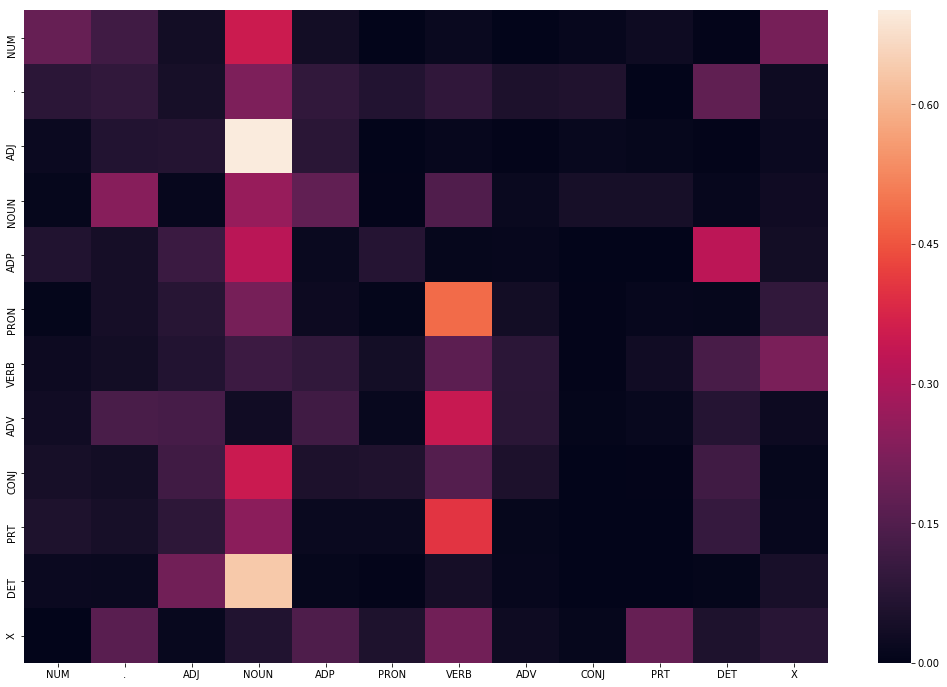

In [25]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


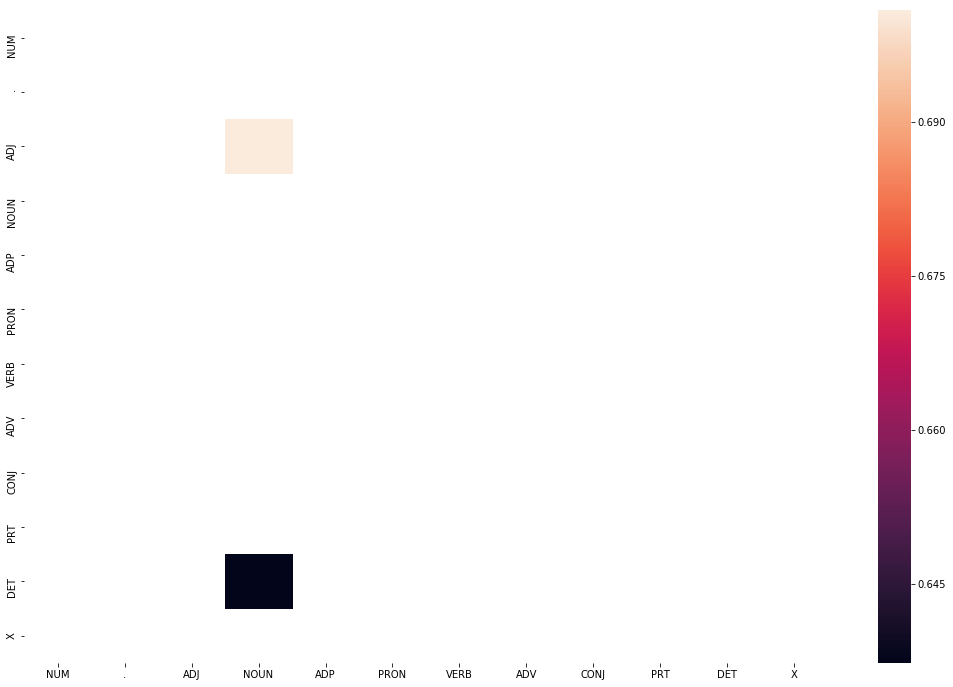

In [26]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

- Thus we observe that the probability of a NOUN appearing after a DET (determiner) is higher
- The probability of a NOUN appearing after an ADJ (Adjective) is also higher


## Data Preparation - Validation Set

In [27]:
# list of tagged words
valdn_run_base = [tup for sent in valdn_set for tup in sent]

# list of untagged words
valdn_tagged_words = [tup[0] for sent in valdn_set for tup in sent]
valdn_run_base[:10]


[('Investors', 'NOUN'),
 ('took', 'VERB'),
 ('advantage', 'NOUN'),
 ('of', 'ADP'),
 ('Tuesday', 'NOUN'),
 ("'s", 'PRT'),
 ('stock', 'NOUN'),
 ('rally', 'NOUN'),
 ('*-1', 'X'),
 ('to', 'PRT')]

### Data Preparation - Sample Test File

In [28]:
# The path of the sample test file
path = r'D:\Maria\Data Science\Data Files\NLP Assignment'

In [29]:
with open(path + "\\" + "Test_sentences.txt", "r") as file:
    data = file.read().replace('\n', ' ')
samp_file_words = word_tokenize(data)

In [30]:
# Tagging sample file with Universal tag
sample_tagged_words = nltk.pos_tag(samp_file_words, tagset='universal')
sample_tagged_words

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADJ'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('se

### Creating commonly used functions to evaluate Validation/Test Data, calculate accuracy and to get incorrect tagged sentences

#### Function to evaluate the Viterbi and modified Algorithms over validation data / test data

In [31]:
def test_evaluate(Func_name,test_data):
    start = time.time()
    tagged_seq = Func_name(test_data)
    end = time.time()
    difference = end - start
    return difference,tagged_seq

#### Function to calculate accuracy of the algorithm

In [32]:
def get_accuracy(tagged_seq, test_run_base):
    check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
    accuracy = len(check)/len(tagged_seq)
    return(accuracy)


#### Function to get incorrectly tagged words

In [33]:
def get_incorrect_tagged_cases(tagged_seq, test_run_base):
    incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
    return(incorrect_tagged_cases)


#### Function to get the word and its tag from a given sequence

In [34]:
def get_tag (word, seq_name):
    
    for i,val in enumerate(seq_name):
        if val[0] == word:
            return (val)

### Vanilla Viterbi based POS tagger

- Viterbi algorithm is an example of dynamic programming algorithm.
- Hidden Markov Model - The task of learning transition and emission probabilities using some tagged corpus, such as the Penn Treebank, is called the learning problem.
- Viterbi Algorithm - is the explanation/decoding problem, which solves using the learning problem. 

- Viterbi algorithm: For every word w in the sentence, a tag t is assigned to w such that it maximises the likelihood of the occurrence of P(tag|word), where 

P(tag|word) = P(word|tag) * P(tag|previous tag)

            = Emission probability * Transition probability
            

### The Vanilla Viterbi Algorithm

In [35]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluation of Vanilla Viterbi algorithm over Validation set

In [36]:
time_taken = test_evaluate(Viterbi, valdn_tagged_words)[0]
valdn_seq_Viterbi = test_evaluate(Viterbi, valdn_tagged_words)[1]
print("Evaluation time taken (in seconds) for Viterbi algorithm on validation set: ",time_taken)
print(valdn_seq_Viterbi)


Evaluation time taken (in seconds) for Viterbi algorithm on validation set:  2239.8753089904785
[('Investors', 'NOUN'), ('took', 'VERB'), ('advantage', 'NOUN'), ('of', 'ADP'), ('Tuesday', 'NOUN'), ("'s", 'PRT'), ('stock', 'NOUN'), ('rally', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('book', 'NOUN'), ('some', 'DET'), ('profits', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('*-1', 'X'), ('leaving', 'VERB'), ('stocks', 'NOUN'), ('up', 'PRT'), ('fractionally', 'ADV'), ('.', '.'), ('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried', 'VERB'), ('over', 'ADP'), ('from', 'ADP'), ('the', 'DET'), ('previous', 'ADJ'), ('session', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('traders', 'NOUN'), ('apparently', 'ADV'), ('ignored', 'NUM'), ('reports', 'NOUN'), ('that', 'ADP'), ('a', 'DET'), ('Chilean', 'ADJ'), ('mine', 'NOUN'), ('strike', 'NOUN'), ('may', 'VERB'), ('have', 'VERB'), ('ended', 'VERB'), ('almost', 'ADV'), ('before', 'ADP'), ('it', 'PRON'), ('began', 'V

In [37]:
accu = get_accuracy(valdn_seq_Viterbi, valdn_run_base)
print("Accuracy of Vanilla Viterbi over Validation Data :", round(accu * 100,2),"%")

Accuracy of Vanilla Viterbi over Validation Data : 91.03 %


In [38]:
print("Vanilla Viterbi - Incorrect Tagged words - Validation Data")
get_incorrect_tagged_cases(valdn_seq_Viterbi, valdn_run_base)

Vanilla Viterbi - Incorrect Tagged words - Validation Data


[[('to', 'PRT'), (('book', 'NOUN'), ('book', 'VERB'))],
 [('leaving', 'VERB'), (('stocks', 'NOUN'), ('stocks', 'ADV'))],
 [('stocks', 'ADV'), (('up', 'PRT'), ('up', 'ADP'))],
 [('carried', 'VERB'), (('over', 'ADP'), ('over', 'PRT'))],
 [('apparently', 'ADV'), (('ignored', 'NUM'), ('ignored', 'VERB'))],
 [('Chilean', 'ADJ'), (('mine', 'NOUN'), ('mine', 'ADJ'))],
 [('the', 'DET'), (('Palestinian', 'ADJ'), ('Palestinian', 'NOUN'))],
 [('committee', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))],
 [('.', '.'), (('Preston', 'NUM'), ('Preston', 'NOUN'))],
 [('Foster', 'NOUN'), (('Birmingham', 'NUM'), ('Birmingham', 'NOUN'))],
 [(',', '.'), (('Ala', 'NUM'), ('Ala', 'NOUN'))],
 [('has', 'VERB'), (('clamped', 'NUM'), ('clamped', 'VERB'))],
 [('their', 'PRON'), (('ankle', 'NUM'), ('ankle', 'NOUN'))],
 [('the', 'DET'), (('third-largest', 'NUM'), ('third-largest', 'ADJ'))],
 [('the', 'DET'), (('fifth-largest', 'NUM'), ('fifth-largest', 'ADJ'))],
 [('Charles', 'NOUN'), (('Z.', 'NUM'), ('Z.', 'NOUN'

### Observation of Unknown words:

<b> From the above list of incorrectly tagged words i.e the list of words unknown to the trained corpus: </b> <br> <br>
Three incorrect tags are given for example
- NOUN <b> 'Birmingham' </b> incorrectly identified as 'NUM ('Birmingham', 'NUM')
- VERB <b> 'safeguarding' </b> incorrectly identified as 'NUM' ('safeguarding', 'NUM')
- VERB <b> 'ignored' </b> incorrectly identified as 'NUM' - ('ignored', 'NUM')

Since 'NUM' is the first tag, 'NUM' is mostly assigned as POS tag for most of the unknown words.

### Evaluation of Vanilla Viterbi Algorithm over Sample Test File

In [39]:
time_taken = test_evaluate(Viterbi, samp_file_words)[0]
sample_seq_Viterbi = test_evaluate(Viterbi, samp_file_words)[1]
print("Evaluation time taken (in seconds) for Vanilla Viterbi on Sample Test File: ",time_taken)
print(sample_seq_Viterbi)

Evaluation time taken (in seconds) for Vanilla Viterbi on Sample Test File:  117.91891193389893
[('Android', 'NUM'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NUM'), ('.', '.'), ('Android', 'NUM'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NUM'), ('worldwide', 'NUM'), ('on', 'ADP'), ('smartphones', 'NUM'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NUM'), ('and', 'CONJ'), ('Twitter', 'NUM'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NUM'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NUM'), ("'s", 'PRT'), ('firehose', 'NUM'), ('.', '.'), ('Twitter', 'NUM'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NUM'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ

In [40]:
accu = get_accuracy(sample_seq_Viterbi, sample_tagged_words)
print("Accuracy of Vanilla Viterbi Evaluation over Sample Test Data :", round(accu * 100,2),"%")

Accuracy of Vanilla Viterbi Evaluation over Sample Test Data : 79.01 %


In [41]:
print("Vanilla Viterbi - Incorrect Tagged words - Sample Test Data")
get_incorrect_tagged_cases(sample_seq_Viterbi, sample_tagged_words)

Vanilla Viterbi - Incorrect Tagged words - Sample Test Data


[[('.', '.'), (('Android', 'NUM'), ('Android', 'NOUN'))],
 [('by', 'ADP'), (('Google', 'NUM'), ('Google', 'NOUN'))],
 [('.', '.'), (('Android', 'NUM'), ('Android', 'NOUN'))],
 [('best-selling', 'ADJ'), (('OS', 'NUM'), ('OS', 'NOUN'))],
 [('OS', 'NOUN'), (('worldwide', 'NUM'), ('worldwide', 'NOUN'))],
 [('on', 'ADP'), (('smartphones', 'NUM'), ('smartphones', 'NOUN'))],
 [('.', '.'), (('Google', 'NUM'), ('Google', 'NOUN'))],
 [('and', 'CONJ'), (('Twitter', 'NUM'), ('Twitter', 'NOUN'))],
 [('2015', 'NUM'), (('that', 'ADP'), ('that', 'DET'))],
 [('gave', 'VERB'), (('Google', 'NUM'), ('Google', 'NOUN'))],
 [('to', 'PRT'), (('Twitter', 'NUM'), ('Twitter', 'NOUN'))],
 [("'s", 'PRT'), (('firehose', 'NUM'), ('firehose', 'NOUN'))],
 [('.', '.'), (('Twitter', 'NUM'), ('Twitter', 'NOUN'))],
 [('an', 'DET'), (('online', 'NUM'), ('online', 'ADJ'))],
 [('and', 'CONJ'), (('interact', 'NUM'), ('interact', 'NOUN'))],
 [('with', 'ADP'), (('messages', 'NUM'), ('messages', 'NOUN'))],
 [('as', 'ADP'), (('tw

### Observation of Unknown words:

<b> From the above list of incorrectly tagged words i.e the list of words unknown to the trained corpus: </b> <br> <br>
Three incorrect tags are given for example
- NOUN <b> 'Android' </b> incorrectly identified as 'NUM' - ('Android', 'NUM')
- NOUN <b> 'tournament' </b> incorrectly identified as 'NUM' ('tournament', 'NUM')
- NOUN <b> 'Satellite' </b> incorrectly identified as 'NUM' ('Satellite', 'NUM')

Since 'NUM' is the first tag, 'NUM' is mostly assigned as POS tag for most of the unknown words.

## Solve the problem of unknown words

<b> Disadvantage with Vanilla Viterbi Algorithm: </b>
- The Algorithm learns from the HMM model parameters (Emission and Transition probabilities) obtained from a trained corpus.
- If the word to be tagged is not known to the trained corpus, the first tag is assigned by default, which is not correct.
- This leads to a dropped accuracy

<b> Modifications to overcome the drawback of Vanilla Viterbi Algorithm: <br>
Modification 1 : </b>
- The POS tag of unknown words can be assigned using only the maximum likelihood of transition probabilities and omitting emission probability.
- Thus the probability of the word emitted in the corpus is ignored.

<b> Modification 2 : </b>
- The unknown words are marked with tag 'UNK'
- The POS tags for the unknown words are assigned using regular expression based rules.

### Modification 1 - Viterbi modified to consider only the max likelihood of transition probabilities of Unknown Words

In [42]:
# Modified Viterbi Heuristic - Using only the transition probability of unknown words
def Viterbi_Using_Transition(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        
        #initialise list of transition probability column for a given observation 
        trans_prob = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
            trans_prob.append(transition_p) 
            
            # compute emission and state probabilities 
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p   
            p.append(state_probability)
            
        # getting state for which probability is maximum
        pmax = max(p)  
        
        # if the word is not present in the trained corpus, we take the maximum of transition probability of that word
        # And assign the respective Tag
        if pmax==0:
            pmax = max(trans_prob)
            state_max = T[trans_prob.index(pmax)] 
        else:                      
            state_max = T[p.index(pmax)] 
        state.append(state_max) 
    return list(zip(words, state))


### Modification 2 - Viterbi Modification using rule based POS Tagging of unknown words 

In [43]:
def get_rule_based_tag(words,state):
    
    patterns = [
                    (r'.*ing$', 'VERB'),              # Verb
                    (r'.*ed$', 'VERB'),               # Verb
                    (r'.*es$', 'VERB'),               # Verb
                    (r'.*ould$', 'X'),              # modals marked as X
                    (r'.*\'s$', 'NOUN'),              # nouns
                    (r'.*s$', 'NOUN'),                # nouns
                    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # numbers
                    (r'.*', 'NOUN')                   # noun
                ]

    
    regexp_tagger = nltk.RegexpTagger(patterns)
    
    for i,j in enumerate(state):
        #Rule-based tagging done only for new 'unknown' words.
        if j == "UNK":
            state[i] = regexp_tagger.tag([words[i]])[0][1]
    return words,state

In [44]:
# Modified Viterbi Heuristic with Rule Based
def Viterbi_Using_Rule_Based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else: 
                # If the previous tag is 'UNK' set the transition probability to 1
                # Thus the emission probability alone will be taken for the unknown words
                if state[-1] == 'UNK':
                    transition_p = 1
                else:             
                    transition_p = tags_df.loc[state[-1], tag]
                
           
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)   
        pmax = max(p)

        if pmax == 0:
            # set the tag 'UNK' for unknown words
            state_max = "UNK"
        else:
            state_max = T[p.index(pmax)]
        state.append(state_max)
    
    # Get the tag of unknown words using rule based POS tagging
    word, state = get_rule_based_tag(words, state) 
    return list(zip(words, state))

## Evaluating tagging accuracies

### Modification 1 - Viterbi modified Using only  the maximum likelihood of Transition Probabilities of unknown words

### Evaluation - over Validation Set

In [45]:
time_taken = test_evaluate(Viterbi_Using_Transition, valdn_tagged_words)[0]
valdn_seq_mod1 = test_evaluate(Viterbi_Using_Transition, valdn_tagged_words)[1]
print("Evaluation time taken (in seconds) for Viterbi modified using transition probability on validation set: ",time_taken)
print(valdn_seq_mod1)

Evaluation time taken (in seconds) for Viterbi modified using transition probability on validation set:  2249.7652378082275
[('Investors', 'NOUN'), ('took', 'VERB'), ('advantage', 'NOUN'), ('of', 'ADP'), ('Tuesday', 'NOUN'), ("'s", 'PRT'), ('stock', 'NOUN'), ('rally', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('book', 'NOUN'), ('some', 'DET'), ('profits', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('*-1', 'X'), ('leaving', 'VERB'), ('stocks', 'NOUN'), ('up', 'PRT'), ('fractionally', 'ADV'), ('.', '.'), ('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried', 'VERB'), ('over', 'ADP'), ('from', 'ADP'), ('the', 'DET'), ('previous', 'ADJ'), ('session', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('traders', 'NOUN'), ('apparently', 'ADV'), ('ignored', 'VERB'), ('reports', 'NOUN'), ('that', 'ADP'), ('a', 'DET'), ('Chilean', 'ADJ'), ('mine', 'NOUN'), ('strike', 'NOUN'), ('may', 'VERB'), ('have', 'VERB'), ('ended', 'VERB'), ('almost', 'ADV'), ('before', 'ADP'),

### Calculating Accuracy of Validation Data

In [46]:
accu = get_accuracy(valdn_seq_mod1, valdn_run_base)
print("Accuracy of Viterbi modified using Transition Probability over Validation Data :", round(accu * 100,2),"%")

Accuracy of Viterbi modified using Transition Probability over Validation Data : 93.31 %


### Validation Data - TEST CASES
### Word Tags corrected by Viterbi modified using only transition probabilities of unknown words

#### TEST CASE 1

In [66]:
# Test Case 1
print("Word - \"Birmingham\" corrected by Viterbi Modified using transition probabilities of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("Birmingham", valdn_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("Birmingham", valdn_seq_mod1))

Word - "Birmingham" corrected by Viterbi Modified using transition probabilities of unknown words
Viterbi - Incorrect word Tag:  ('Birmingham', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('Birmingham', 'NOUN')


#### POS tag of the word Birmingham being name of a place is corrected to 'NOUN' tag

#### TEST CASE 2

In [67]:
# Test Case 2
print("Word - \"safeguarding\" corrected by Viterbi Modified using transition probabilities of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("safeguarding", valdn_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("safeguarding", valdn_seq_mod1))

Word - "safeguarding" corrected by Viterbi Modified using transition probabilities of unknown words
Viterbi - Incorrect word Tag:  ('safeguarding', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('safeguarding', 'VERB')


#### The POS tag of the word 'safeguarding' is corrected to 'VERB' tag

#### TEST CASE 3

In [68]:
# Test Case 3
print("Word - \"ignored\" corrected by Viterbi Modified using transition probabilities of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("ignored", valdn_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("ignored", valdn_seq_mod1))

Word - "ignored" corrected by Viterbi Modified using transition probabilities of unknown words
Viterbi - Incorrect word Tag:  ('ignored', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('ignored', 'VERB')


#### The POS tag of the word 'ignored' is corrected to 'VERB' tag

### Viterbi modified Using only Transition Probability of unknown words

### Evaluation on sample data set

In [50]:
time_taken = test_evaluate(Viterbi_Using_Transition, samp_file_words)[0]
sample_seq_mod1 = test_evaluate(Viterbi_Using_Transition, samp_file_words)[1]
print("Evaluation time taken (in seconds) for Viterbi using transition probability on sample test data: ",time_taken)
print(sample_seq_mod1)

Evaluation time taken (in seconds) for Viterbi using transition probability on sample test data:  67.8572587966919
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and

### Calculating accuracy on sample test data

In [51]:
accu = get_accuracy(sample_seq_mod1, sample_tagged_words)   
print("Accuracy of Viterbi Modified Using Transition probability over Sample Test Data :", round(accu * 100,2),"%")

Accuracy of Viterbi Modified Using Transition probability over Sample Test Data : 86.74 %


### Sample Test Data  - TEST CASES
### Word Tags corrected by Viterbi modified using only transition probabilities of unknown words

#### TEST CASE 1

In [69]:
# Test Case 1
print("Word - \"Android\" corrected by Viterbi Modified using transition probabilities of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("Android", sample_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("Android", sample_seq_mod1))

Word - "Android" corrected by Viterbi Modified using transition probabilities of unknown words
Viterbi - Incorrect word Tag:  ('Android', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('Android', 'NOUN')


#### The POS tag of the word 'Android' corrected to 'NOUN' tag

#### TEST CASE 2

In [73]:
# Test Case 2
print("Word - \"tournament\" corrected by Viterbi Modified using transition probabilities of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("tournament", sample_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("tournament", sample_seq_mod1))

Word - "tournament" corrected by Viterbi Modified using transition probabilities of unknown words
Viterbi - Incorrect word Tag:  ('tournament', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('tournament', 'NOUN')


#### The POS tag of the word 'tournament' corrected to 'NOUN' tag

#### TEST CASE 3

In [74]:
# Test Case 3
print("Word - \"Satellite\" corrected by Viterbi Modified using transition probabilities of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("Satellite", sample_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("Satellite", sample_seq_mod1))

Word - "Satellite" corrected by Viterbi Modified using transition probabilities of unknown words
Viterbi - Incorrect word Tag:  ('Satellite', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('Satellite', 'NOUN')


#### The POS tag of the word 'Satellite' corrected to NOUN

## Modification2 - Viterbi modified for POS Tagging of unknown words using rule based approach 

### Evaluation on Validation Set

In [55]:
time_taken = test_evaluate(Viterbi_Using_Rule_Based, valdn_tagged_words)[0]
valdn_seq_mod2 = test_evaluate(Viterbi_Using_Rule_Based, valdn_tagged_words)[1]
print("Evaluation time taken (in seconds) for Viterbi using rule based tagging on validation data: ",time_taken)
print(valdn_seq_mod2)

Evaluation time taken (in seconds) for Viterbi using rule based tagging on validation data:  1779.8907177448273
[('Investors', 'NOUN'), ('took', 'VERB'), ('advantage', 'NOUN'), ('of', 'ADP'), ('Tuesday', 'NOUN'), ("'s", 'PRT'), ('stock', 'NOUN'), ('rally', 'NOUN'), ('*-1', 'X'), ('to', 'PRT'), ('book', 'NOUN'), ('some', 'DET'), ('profits', 'NOUN'), ('yesterday', 'NOUN'), (',', '.'), ('*-1', 'X'), ('leaving', 'VERB'), ('stocks', 'NOUN'), ('up', 'PRT'), ('fractionally', 'ADV'), ('.', '.'), ('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried', 'VERB'), ('over', 'ADP'), ('from', 'ADP'), ('the', 'DET'), ('previous', 'ADJ'), ('session', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('traders', 'NOUN'), ('apparently', 'ADV'), ('ignored', 'VERB'), ('reports', 'NOUN'), ('that', 'ADP'), ('a', 'DET'), ('Chilean', 'ADJ'), ('mine', 'NOUN'), ('strike', 'NOUN'), ('may', 'VERB'), ('have', 'VERB'), ('ended', 'VERB'), ('almost', 'ADV'), ('before', 'ADP'), ('it', 'PRO

### Accuracy - Validation data

In [56]:
accu = get_accuracy(valdn_seq_mod2, valdn_run_base)
print("Accuracy of Viterbi modified using rule based over Validation Data :", round(accu * 100,2),"%")

Accuracy of Viterbi modified using rule based over Validation Data : 94.75 %


### Validation Data - TEST CASES
### Word Tags corrected by Viterbi modified using rule based POS tagging of unknown words

#### TEST CASE 1

In [88]:
# Test Case 1
print("Text - \"deteriorating\" corrected by Viterbi Modified using rule based POS tagging of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("deteriorating", valdn_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("deteriorating", valdn_seq_mod2))

Text - "deteriorating" corrected by Viterbi Modified using rule based POS tagging of unknown words
Viterbi - Incorrect word Tag:  ('deteriorating', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('deteriorating', 'VERB')


#### The POS tag of word 'deteriorating' corrected to VERB

#### TEST CASE 2

In [78]:
# Test Case 2
print("Word - \"relevance\" corrected by Viterbi Modified using rule based POS tagging of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("relevance", valdn_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("relevance", valdn_seq_mod2))

Word - "relevance" corrected by Viterbi Modified using rule based POS tagging of unknown words
Viterbi - Incorrect word Tag:  ('relevance', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('relevance', 'NOUN')


#### The POS tag of the word 'relevance' corrected to NOUN

#### TEST CASE 3

In [79]:
# Test Case 3
print("Word - \"diagnosed\" corrected by Viterbi Modified using rule based POS tagging of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("diagnosed", valdn_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("diagnosed", valdn_seq_mod2))

Word - "diagnosed" corrected by Viterbi Modified using rule based POS tagging of unknown words
Viterbi - Incorrect word Tag:  ('diagnosed', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('diagnosed', 'VERB')


#### The POS tag of word 'diagnosed' corrected to VERB

### Evaluation - Sample Test Data

In [60]:
time_taken = test_evaluate(Viterbi_Using_Rule_Based, samp_file_words)[0]
sample_seq_mod2 = test_evaluate(Viterbi_Using_Rule_Based, samp_file_words)[1]
print("Evaluation time taken (in seconds) for Viterbi using rule based on sample test data: ",time_taken)
print(sample_seq_mod2)

Evaluation time taken (in seconds) for Viterbi using rule based on sample test data:  69.27740120887756
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CO

### Accuracy - Sample test Data

In [61]:
accu = get_accuracy(sample_seq_mod2, sample_tagged_words)
print("Accuracy of Viterbi modified using rule based over Sample Test Data :", round(accu * 100,2),"%")

Accuracy of Viterbi modified using rule based over Sample Test Data : 92.82 %


### Sample Test Data - TEST CASES  
### Word Tags corrected by Viterbi modified using rule based POS tagging of unknown words

#### TEST CASE 1

In [81]:
# Test Case 1
print("Text - \"Google\" corrected by Viterbi Modified using rule based POS tagging of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("Google", sample_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("Google", sample_seq_mod2))

Text - "Google" corrected by Viterbi Modified using rule based POS tagging of unknown words
Viterbi - Incorrect word Tag:  ('Google', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('Google', 'NOUN')


#### The POS tag of text 'Google' corrected to NOUN

#### TEST CASE 2

In [82]:
# Test Case 2
print("Word - \"Twitter\" corrected by Viterbi Modified using rule based POS tagging of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("Twitter", sample_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("Twitter", sample_seq_mod2))

Word - "Twitter" corrected by Viterbi Modified using rule based POS tagging of unknown words
Viterbi - Incorrect word Tag:  ('Twitter', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('Twitter', 'NOUN')


#### The POS tag of the word 'Twitter' corrected to NOUN

#### TEST CASE 3

In [83]:
# Test Case 3
print("Word - \"ICESAT-2\" corrected by Viterbi Modified using rule based POS tagging of unknown words")
print("Viterbi - Incorrect word Tag: ",get_tag("ICESAT-2", sample_seq_Viterbi))
print("Viterbi Modified using transition probabilities of unknown words - Corrected word Tag: ",get_tag("ICESAT-2", sample_seq_mod2))

Word - "ICESAT-2" corrected by Viterbi Modified using rule based POS tagging of unknown words
Viterbi - Incorrect word Tag:  ('ICESAT-2', 'NUM')
Viterbi Modified using transition probabilities of unknown words - Corrected word Tag:  ('ICESAT-2', 'NOUN')


#### The POS tag of the word 'ICESAT-2' corrected to NOUN

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

#### Summary – Accuracies of Viterbi and modified versions
|Data Evaluated | Original Viterbi Algorithm	 | Viterbi modified using only transition probability for unknown words | Viterbi modified using rule based POS tagging of unknown words |
| --- | --- | --- | --- |
| Validation Data | 91.03%  | 93.31% | 94.75% |
|Sample Test Data | 79.01% | 86.74% | 92.82% |


- The Vanilla Viterbi algorithm initially had an accuracy of 91.03% and 79.01% on validation set and test set respectively.
- The Viterbi algorithm modified to tag the unknown words using only the maximum likelihood of transition probabilities has an increased accuracy of 93.31% and 86.74% on validation data and test data respectively.
- The Viterbi algorithm modified to tag the unknown words using rule based POS tagging has shown much greater accuracy of 94.75% and 92.82% on validation data and test data respectively

<b> Thus we observe that Modification 2 - Viterbi modified to tag the unknown words using rule based POS tagging seems to be the best approach for the given sample test data </b>

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

### Modification 1:
#### Incorrect Tags Corrected  by Viterbi modified using only transition probability for unknown words
|Data Evaluated | Test Cases | Original Viterbi Algorithm - Incorrect Tags	 | Viterbi modified using only transition probability for unknown words - Corrected Tags | Description |
| --- | --- | --- | --- | --- |
| Validation Data | Test Case 1 | ('ignored', 'NUM')  | ('ignored', 'VERB') | POS tag of 'ignored' is corrected to Verb | 
| -- | Test Case 2 | ('Birmingham', 'NUM') | ('Birmingham', 'NOUN') | POS tag of 'Birmingham' is corrected to Noun |
| -- | Test Case 3 | ('safeguarding', 'NUM') | ('safeguarding', 'VERB') | POS tag of 'safeguarding' is corrected to Verb |
| --- | --- | --- | --- | --- |
| Sample Test Data | Test Case 1 | ('Android', 'NUM') | ('Android', 'NOUN') | POS tag of 'Android' is corrected to Noun |
| --- | Test Case 2 | ('tournament', 'NUM') | ('tournament', 'NOUN') | POS tag of 'tournament' is corrected to Noun |
| --- | Test Case 3 | ('Satellite', 'NUM') | ('Satellite', 'NOUN') | POS tag of 'Satellite' corrected to Noun |

### Modification 2:
#### Incorrect Tags Corrected  by Viterbi modified using rule based POS tagging of unknown words 
|Data Evaluated | Test Cases | Original Viterbi Algorithm - Incorrect Tags	 | Viterbi modified using rule based POS tagging of unknown words  - Corrected Tags | Description |
| --- | --- | --- | --- | --- |
| Validation Data | Test Case 1 | ('deteriorating', 'NUM') | ('deteriorating', 'VERB') | POS tag of 'deteriorating' corrected to VERB |
| --- | Test Case 2 | ('relevance', 'NUM') | ('relevance', 'NOUN') | POS tag of 'relevance' corrected to NOUN |
| --- | Test Case 3 | ('diagnosed', 'NUM') | ('diagnosed', 'VERB') | POS tag of 'diagnosed' corrected to VERB |
| --- | --- | --- | --- |
| Sample Test Data | Test Case 1 | ('Google', 'NUM') | ('Google', 'NOUN') | POS tag of 'Google' corrected to NOUN |
| --- | Test Case 2 | ('Twitter', 'NUM') | ('Twitter', 'NOUN') | POS tag of 'Twitter' corrected to NOUN |
| --- | Test Case 3 | ('ICESAT-2', 'NUM') | ('ICESAT-2', 'NOUN') | POS tag of 'ICESAT-2' corrected to NOUN |

- Thus we understand that the initial Viterbi algorithm had some drawbacks which led to the lower accuracy rates. 
- After modifying the algorithm to correct the unknown tags, most of the words were correctly tagged leading to an increased accuracy rate 
    